<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Обучение-модели-LightGBM" data-toc-modified-id="Обучение-модели-LightGBM-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Обучение модели LightGBM</a></span></li><li><span><a href="#Обучение-моделей-LinearRegression-и-DecisionTreeRegressor" data-toc-modified-id="Обучение-моделей-LinearRegression-и-DecisionTreeRegressor-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Обучение моделей LinearRegression и DecisionTreeRegressor</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#  Прогнозирование заказов такси

Описание проекта.
Название проекта: Прогнозирование заказов такси.

Описание исследования: Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.

Цель исследования: Построить модель, умеющую делать такое предсказание. 

Критерии, которые важны заказчику:

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Задачи исследования:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

Исходные данные: Таблица .csv с данными о количестве заказов, разбитые на 10-минутные интервалы.

Данное исследование разделим на несколько частей.

Часть 1. Изучение общей информации:

Изучение файлов с данными, получение общей информации, загрузка библиотек.
Приведение данных к нужному виду и типам.

Часть 2. Подготовка данных:

Нахождение и ликвидация пропусков.
Проверка и ликвидация дубликатов.
Исследовательский анализ данных - нахождение и исправление аномалий и ошибок.

Часть 3. Обучение моделей:

Обучение модели LightGBM.
Обучение модели LinearRegression.
Обучение модели DesicionTreeRegressor.

Часть 4. Тестирование моделей и итоговые выводы

## Подготовка

In [1]:
pip install -q --upgrade scikit_learn

In [2]:
import pandas as pd
from math import sqrt
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from statsmodels.tsa.stattools import adfuller

In [3]:
RANDOM_STATE = 42
TEST_SIZE = 0.10

Зафиксировали тестовую часть выборки на уровне 10% в соответствии с инструкцией.

In [4]:
warnings.filterwarnings('ignore')

In [5]:
df = pd.read_csv('/datasets/taxi.csv')
df

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
...,...,...
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39


Выяснили,что данные даны за период 6 месяцев: 01-03-2018 - 31-08-2018.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


Данные содержат 2 колонки, тип данных первой не соответствует содержанию данных в ней - дате и времени. Данные не содержат пропусков.

In [7]:
df.duplicated().sum()

0

In [8]:
df['datetime'].duplicated().sum()

0

Данные не содержат полных дубликатов и дубликатов в колонке Datetime

## Анализ

In [9]:
df['num_orders'].describe()

count    26496.000000
mean        14.070463
std          9.211330
min          0.000000
25%          8.000000
50%         13.000000
75%         19.000000
max        119.000000
Name: num_orders, dtype: float64

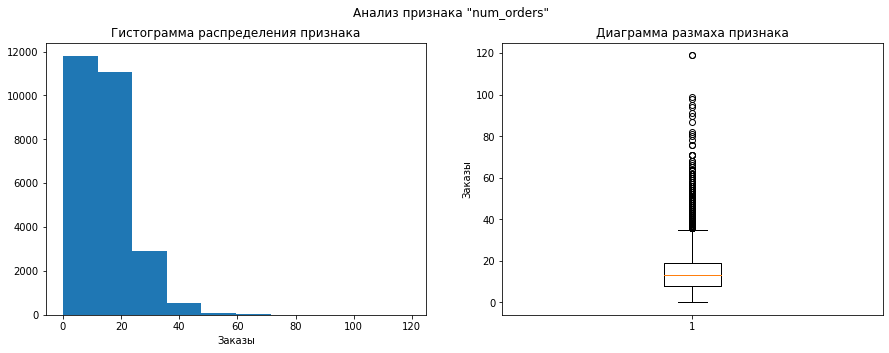

In [10]:
def stat(df):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
    fig.suptitle('Анализ признака "num_orders"')
    axes[0].hist(df);
    axes[0].set_xlabel("Заказы");
    axes[0].set_title('Гистограмма распределения признака');
    axes[1].boxplot(df);
    axes[1].set_title('Диаграмма размаха признака');
    axes[1].set_ylabel("Заказы");
stat(df['num_orders'])

Распределение отдаленно напоминает нормальное со сдвигом влево и выбросами в большую сторону. Миниальное знаечение - 0, максимальное - 119. Медиана -14, среднее - 13, значит выбросы не критичны. Стандартное отклонение 9 - дисперсия данных небольшая.
Приведем первую колонку к типу даты и назначим ее индексом. Проверим ряд на монотонность.

In [11]:
df = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col = 0)
print(df.index.is_monotonic)


True


Ресемплируем данные по 1 часу, тк нам необходимо делать прогноз именно на следующий час.

In [12]:
#df.sort_index(inplace=True)
df = df.resample('1H').sum()
df

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


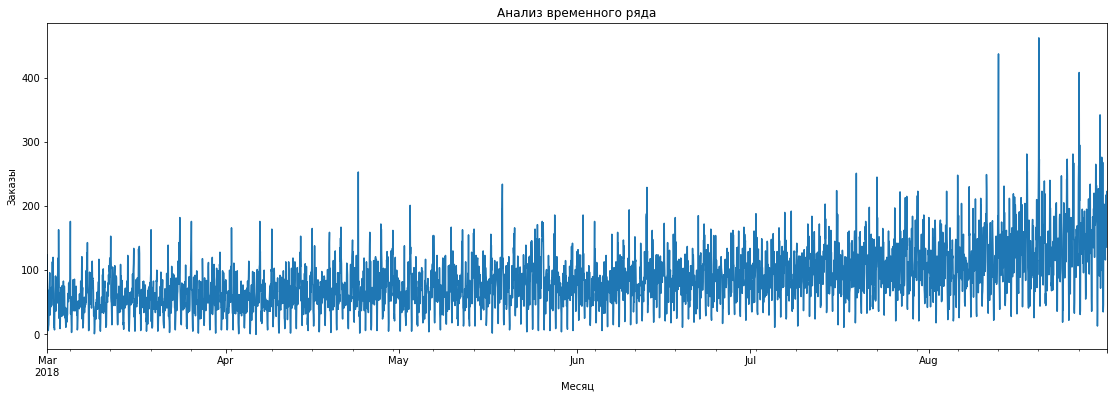

In [13]:
df['num_orders'].plot(figsize = (19,6));
plt.title('Анализ временного ряда');
plt.ylabel("Заказы");
plt.xlabel("Месяц");



Виден возрастающий тренд летом - видимо, связанный с сезоном отпусков и большие выбросы в августе. Рассмотрим август отдельно.

In [14]:
df_aug=df['2018-08-01': '2018-08-31']

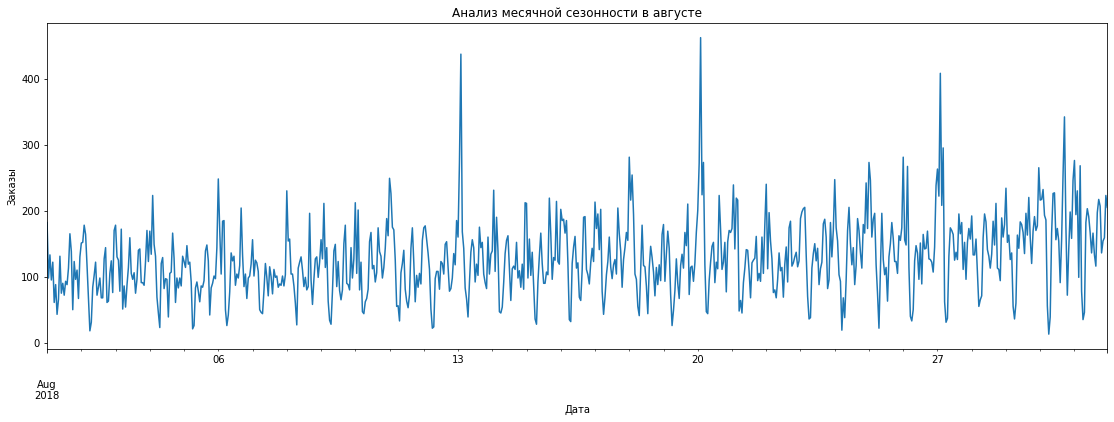

In [15]:
df_aug['num_orders'].plot(figsize = (19,6));
plt.title('Анализ месячной сезонности в августе');
plt.ylabel("Заказы");
plt.xlabel("Дата");


In [16]:
df_aug['dayofweek'] = df_aug.index.dayofweek
df_aug['day'] = df_aug.index.day
print(df_aug.query('day==13')['dayofweek'].unique(), df_aug.query('day==13 and num_orders>400').index)
print(df_aug.query('day==20')['dayofweek'].unique(), df_aug.query('day==20 and num_orders>400').index)
print(df_aug.query('day==27')['dayofweek'].unique(), df_aug.query('day==27 and num_orders>400').index)

[0] DatetimeIndex(['2018-08-13 02:00:00'], dtype='datetime64[ns]', name='datetime', freq='H')
[0] DatetimeIndex(['2018-08-20 02:00:00'], dtype='datetime64[ns]', name='datetime', freq='H')
[0] DatetimeIndex(['2018-08-27 02:00:00'], dtype='datetime64[ns]', name='datetime', freq='H')


Итак, выбросы в августе просходят по воскресеньям около 2 часов ночи - может быть связано с тем, что прилетает какой-то большой рейс. Не будем их удалять.


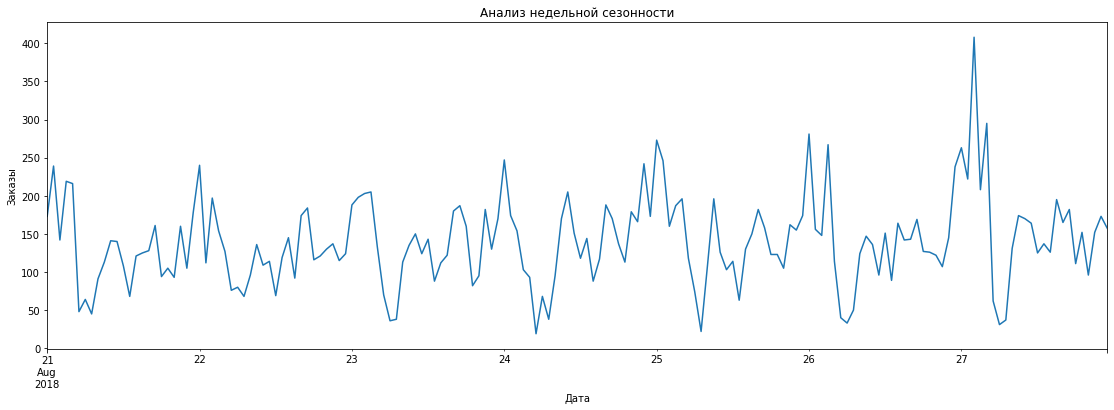

In [17]:
df_week=df['2018-08-21': '2018-08-27']
df_week['num_orders'].plot(figsize = (19,6));
plt.title('Анализ недельной сезонности');
plt.ylabel("Заказы");
plt.xlabel("Дата");

Анализ недельной сезонности  последней недели августа показывает примероно одиковый тренд в течение первой половины недели и увелиение количества заказов в weekend.

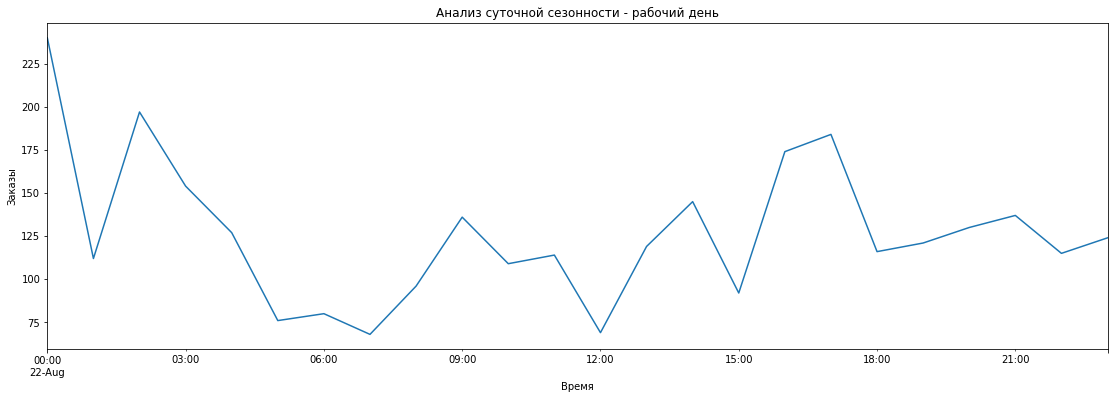

In [18]:
df_day=df['2018-08-22']
df_day['num_orders'].plot(figsize = (19,6));
plt.title('Анализ суточной сезонности - рабочий день');
plt.ylabel("Заказы");
plt.xlabel("Время");

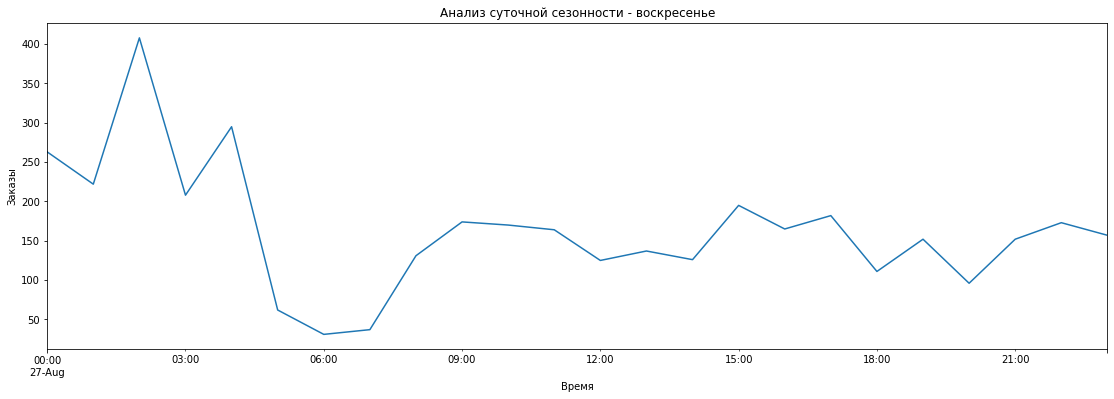

In [19]:
df_day=df['2018-08-27']
df_day['num_orders'].plot(figsize = (19,6));
plt.title('Анализ суточной сезонности - воскресенье');
plt.ylabel("Заказы");
plt.xlabel("Время");

Анализ суточной сезонности показывет, что есть спад количества заказов в утренние часы - видимо, аэропор не работает в это время, далее в течение дня тренд достаточно ровный (особено в выходной день, в будний  видимо скачки спроса зависят от прилета рейсов) и наастает ночью.

Проведем тест Дики-Фуллера на стационарность временного ряда.

In [20]:
result_adf = adfuller(df['num_orders'])
print('ADF Test:')
print(f'ADF Statistic: {result_adf[0]}')
print(f'p-value: {result_adf[1]}')
print(f'Critical Values:')
for key, value in result_adf[4].items():
    print(f'   {key}: {value}')

ADF Test:
ADF Statistic: -3.0689242890279558
p-value: 0.028940051402612906
Critical Values:
   1%: -3.431842162413052
   5%: -2.8621993540813637
   10%: -2.567120978470452


Поскольку значение p-value (0.029) значительно меньше 0.05, мы можем отвергнуть
нулевую гипотезу H₀ о наличии единичного корня. Это означает, что временной ряд
является стационарным по результатам ADF-теста.

## Обучение

На предыдущем этапе анализы мы выявили зависимоть количества заказов от дня недели и времени суток, поэтому  добавим данные  признаки в наш датасет.Напишем функцию для добавления следующих признаков в датасет: день недели, час, отстающие значения, скользящее среднее - от всех этих параметров может зависеть предсказание модели. 

In [21]:
def make_features(df, max_lag, rolling_mean_size):
 
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()

Вызовем функцию с аргументами 168 для отстающих значений (это равно 7 дням недели * 24 часа), тк важно учитывать тренд за последнюю неделю - так мы учтем и текущий месячный, и недельный тренд, и скользящим средним с окном 24 (часа)). Затем удалим строки с пропусками.


In [22]:
make_features(df,168,24)
df=df.dropna()

In [23]:
df.head()

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-08 00:00:00,143,3,0,94.0,127.0,108.0,76.0,50.0,99.0,48.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,60.041667
2018-03-08 01:00:00,78,3,1,143.0,94.0,127.0,108.0,76.0,50.0,99.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,61.833333
2018-03-08 02:00:00,65,3,2,78.0,143.0,94.0,127.0,108.0,76.0,50.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,60.041667
2018-03-08 03:00:00,68,3,3,65.0,78.0,143.0,94.0,127.0,108.0,76.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,61.750000
2018-03-08 04:00:00,60,3,4,68.0,65.0,78.0,143.0,94.0,127.0,108.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,61.833333


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4248 entries, 2018-03-08 00:00:00 to 2018-08-31 23:00:00
Freq: H
Columns: 172 entries, num_orders to rolling_mean
dtypes: float64(169), int64(3)
memory usage: 5.6 MB


### Обучение модели LightGBM

Разделим датасет на обучающую и тестовую выборки, выделим целевой признак - количество заказов.

In [25]:
X_train_lgbm, X_test_lgbm, y_train_lgbm, y_test_lgbm = train_test_split(
    df.drop(['num_orders'], axis=1),
    df['num_orders'],
    test_size = TEST_SIZE, 
    shuffle=False,
    random_state = RANDOM_STATE
   )
#X_test

In [26]:
lgbm_model = lgb.LGBMRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, metric= 'rmse', 
                              random_state=RANDOM_STATE)

В качестве гиперпараметров зададим количество шагов бустинга и глубину дерева.

In [27]:
param_distributions = [
          
    { 'n_estimators': [100,300],
      'max_depth': range(1,3)}
    
]

In [28]:
randomized_search = RandomizedSearchCV(
    lgbm_model, 
    param_distributions, 
    cv=5,
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1,
    random_state=RANDOM_STATE
)


In [29]:
randomized_search.fit(X_train_lgbm, y_train_lgbm) 
print('Лучшая модель LGBM и её параметры:\n\n', randomized_search.best_estimator_)

Лучшая модель LGBM и её параметры:

 LGBMRegressor(max_depth=2, metric='rmse', random_state=42)


In [30]:
lgbm_rmse=-round(randomized_search.best_score_,2)

print ('Метрика лучшей модели LGBM на кросс-валидации:', lgbm_rmse)

Метрика лучшей модели LGBM на кросс-валидации: 21.49


In [31]:
model_lgbm = randomized_search.best_estimator_

Итак, лучшая LGBM модель имеет параметры LGBMRegressor(max_depth=2, metric='rmse', random_state=42) и метрику RMSE на кросс-валидации 21.49. Проверим качество других моделей.

### Обучение моделей LinearRegression и DecisionTreeRegressor

Поменяем тип данных 'hour','dayofweek' на категориальные, чтобы не масштабировать остальные 170 столбцов относитьельно 3х.

In [32]:
df[['hour','dayofweek']]=df[['hour','dayofweek']].astype('object')

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4248 entries, 2018-03-08 00:00:00 to 2018-08-31 23:00:00
Freq: H
Columns: 172 entries, num_orders to rolling_mean
dtypes: float64(169), int64(1), object(2)
memory usage: 5.6+ MB


Заново разделим датасет на обучающую и тестовую выборки, выделим целевой признак - количество заказов.

In [34]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['num_orders'], axis=1),
    df['num_orders'],
    test_size = TEST_SIZE, 
    shuffle=False,
    random_state = RANDOM_STATE
   )

In [35]:
ohe_columns = ['dayofweek', 'hour']

In [39]:
ohe_pipe = Pipeline(
    [
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ]
    )

In [40]:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns)
   ], 
   remainder='passthrough'
)

In [41]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

In [42]:
param_distributions = [
    
    {
        'models': [LinearRegression()],
         
        
    },
   
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 15),
        'models__min_samples_leaf': range(1, 6),
        'models__min_samples_split': range(2, 6),
        'models__max_features': range(2, 10),
             
    }
    
]

In [43]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions, 
    cv=5,
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1,
    random_state=RANDOM_STATE
)

In [44]:
randomized_search.fit(X_train, y_train) 
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
rmse=-round(randomized_search.best_score_,2)
print ('Метрика лучшей модели  на кросс-валидации:', rmse)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['dayofweek', 'hour'])])),
                ('models',
                 DecisionTreeRegressor(max_depth=8, max_features=8,
                                       min_samples_leaf=4, min_samples_split=4,
                                       random_state=42))])
Метрика лучшей модели  на кросс-валидации: 29.64


Итак, лучшей моделью стала DecisionTreeRegressor с параметрами:
DecisionTreeRegressor(max_depth=8, max_features=8, min_samples_leaf=4, min_samples_split=4,random_state=42) и метрикой RMSE на кросс-валидации 29.64. Что делает лучшей моделью LightGBM.

## Тестирование

Протестируем лучшую модель на тестовой выборке.

In [45]:
lgbm_predictions = model_lgbm.predict(X_test_lgbm)
lgbm_rmse = sqrt(mean_squared_error(y_test_lgbm, lgbm_predictions))
print(f"LightGBM RMSE на тестовой выборке: {lgbm_rmse:.0f}")

LightGBM RMSE на тестовой выборке: 38


Итак, лучшая модель LGBM с параметрами LGBMRegressor(max_depth=2, metric='rmse', random_state=42) показала, хотя и хуже чем на кросс-валидации, приемлемый  (RMSE=<48) результат на тестовой выборке: RMSE=38.

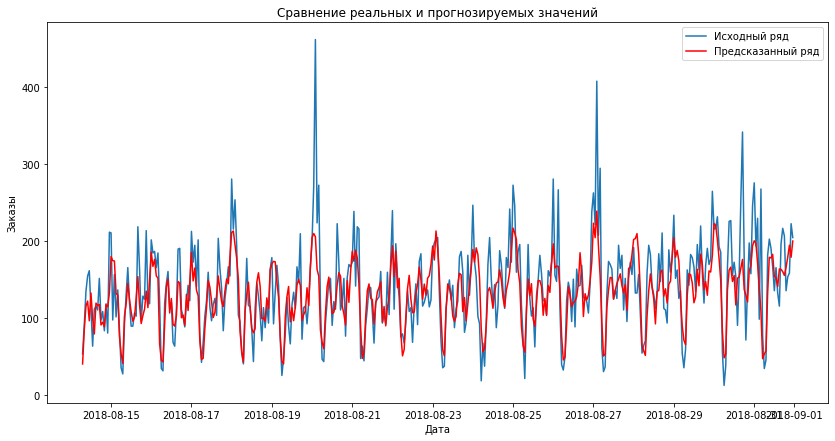

In [46]:
plt.figure(figsize=(14, 7))
plt.plot(y_test.index,y_test_lgbm, label='Исходный ряд')
plt.plot(y_test.index, lgbm_predictions, label='Предсказанный ряд', color='red')
plt.title('Сравнение реальных и прогнозируемых значений')
plt.xlabel('Дата')
plt.ylabel('Заказы')
plt.legend()
plt.show()

График сравнения реальных и прогнозируемых результатов на тестовой выборке показывет, что модель не очень хорощо справляется с прогнрзированием выбросов, но в остальном неплохо справляется с недельной и суточной сезонностью.

Общие выводы:
Итак, был проведен анализ в соответсвии с целями и задачами исследования: была построена модель, прогнозирующая количество заказов такси на следующий час.

На этапе подготовки данных были загружены необходимые библиотеки, данные были проверени на наличия пропусков и дубликатов (не обнаружено). 

На этапе анализа данных было выполнено ресемплироание по одному часу, изучены месячная, недельная и суточные сезонности, ряд был проверен на стационарность. Были изучены аномалии по воскресеньям в августе.

На этапе обучения моделей были обучены 3 модели с помощью инструмента RandomSearch для перебора гиперпараметров c кросс-валидацией: LightGBM, LinearRegression и DecisionTreeRegresor. На кросс валидации лучшей  моделью стала LightGBM с параметрами LGBMRegressor(max_depth=2, random_state=42) - она показало лучшие результаты метрики RMSE на кросс-валидации по сравлению с моделями LinearRegression и DesisionTreeRegressor.

Значение метрики *RMSE* на тестовой выборке не превысило 48 в соответствии с поставленной задачей: RMSE = 38.

Данная модель поможет заказчику привлекать больше водителей в период пиковой нагрузки согласно прогнозу. 

    